In [1]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, LSTM
from tensorflow.keras import callbacks
import math
import numpy as np
import pandas as pd
import string
import random
import pydot
import os

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
train_data = pd.read_csv('../datasets/vqa-v1/train_data.csv')

train_data

,im_path,ques,answ
0,COCO_train2014_000000474075.jpg,What sport is on the TV?,bowling
1,COCO_train2014_000000407548.jpg,Is she playing with a ball?,no
2,COCO_train2014_000000060180.jpg,What is the green vegetable?,broccoli
3,COCO_train2014_000000064141.jpg,What is the green stuff on the food?,basil
4,COCO_train2014_000000403506.jpg,What color is his shirt?,black
...,...,...,...
388149,COCO_train2014_000000247789.jpg,Is there spinach on the pizza?,yes
388150,COCO_train2014_000000151615.jpg,Are there clouds visible?,yes
388151,COCO_train2014_000000363939.jpg,How many trains can be seen?,1
388152,COCO_train2014_000000361275.jpg,What material is the bench made of?,wood


In [5]:
val_data = pd.read_csv('../datasets/vqa-v1/val_data.csv')

val_data

,im_path,ques,answ
0,COCO_val2014_000000069923.jpg,What are they standing on?,sand
1,COCO_val2014_000000387696.jpg,How many people are there?,3
2,COCO_val2014_000000523871.jpg,Where is the wicker chair?,living room
3,COCO_val2014_000000223198.jpg,What color is the subject's tie?,red
4,COCO_val2014_000000341246.jpg,Are these normal-sized donuts?,yes
...,...,...,...
186474,COCO_val2014_000000006789.jpg,Are the cars moving?,yes
186475,COCO_val2014_000000547300.jpg,Is the ball green?,no
186476,COCO_val2014_000000154520.jpg,Are there buildings in the background?,no
186477,COCO_val2014_000000388903.jpg,What company does the man in the background wo...,fedex


In [6]:
test_data = pd.read_csv('../datasets/vqa-v1/test_data.csv')

test_data

,im_path,ques,ques_id
0,COCO_test2015_000000361284.jpg,What color is her surfboard?,361284002
1,COCO_test2015_000000580877.jpg,What is the woman standing on?,580877008
2,COCO_test2015_000000097764.jpg,How many tennis balls are there?,97764005
3,COCO_test2015_000000112725.jpg,Is there cereal in the bowl?,112725009
4,COCO_test2015_000000453690.jpg,What color is the men's sunglasses?,453690003
...,...,...,...
447788,COCO_test2015_000000000565.jpg,What is the cat laying on?,565000
447789,COCO_test2015_000000129714.jpg,How many beer bottles are on the table?,129714005
447790,COCO_test2015_000000165846.jpg,What sports equipment is he holding?,165846001
447791,COCO_test2015_000000272125.jpg,Why is the cat dressed up?,272125002


In [7]:
train_image_embeddings = dict()
directory = '../datasets/vqa-v1/images/train_image_features/'
files = os.listdir(directory)
for i, file in enumerate(files):
    #print('processed',i+1,'features',end='\r')
    feature = np.load(directory+file)['arr_0']
    name = file[:-4]
    train_image_embeddings[name] = feature

In [8]:
val_image_embeddings = dict()
directory = '../datasets/vqa-v1/images/val_image_features/'
files = os.listdir(directory)
for i, file in enumerate(files):
    #print('processed',i+1,'features',end='\r')
    feature = np.load(directory+file)['arr_0']
    name = file[:-4]
    val_image_embeddings[name] = feature

In [9]:
#question feature extraction
#glove embeddings

glove_embeddings = dict()
f = open('../datasets/pre-trained/glove/glove.6B.300d.txt', encoding='utf-8')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float64')
  glove_embeddings[word] = coefs
f.close()

print(len(glove_embeddings))
print(glove_embeddings['king'][:50])

400000
[ 0.0033901 -0.34614    0.28144    0.48382    0.59469    0.012965
  0.53982    0.48233    0.21463   -1.0249    -0.34788   -0.79001
 -0.15084    0.61374    0.042811   0.19323    0.25462    0.32528
  0.05698    0.063253  -0.49439    0.47337   -0.16761    0.045594
  0.30451   -0.35416   -0.34583   -0.20118    0.25511    0.091111
  0.014651  -0.017541  -0.23854    0.48215   -0.9145    -0.36235
  0.34736    0.028639  -0.027065  -0.036481  -0.067391  -0.23452
 -0.13772    0.33951    0.13415   -0.1342     0.47856   -0.1842
  0.10705   -0.45834  ]


In [10]:
#answer feature extraction
answers = list(pd.unique(train_data['answ']))
random.shuffle(answers)
print(answers[:100])

['stuffed animals', '20', 'statue', 'clock', 'food', 'saddle', 'beer', '30', 'surf', 'plants', 'pole', 'waves', 'road', 'ski', '8', 'cabinet', 'heart', 'gold', 'women', 'sitting', 'cake', 'trees', 'not possible', 'wii controller', 'warm', 'teddy bears', 'tulips', '21', 'blue and white', 'string', '1', 'pelican', 'dog', 'yes', 'window', 'cone', 'fireplace', 'vest', 'sun', 'female', 'brick', 'pillow', 'waiting', 'ski lift', 'overcast', 'fall', 'strawberry', 'dining room', 'red and blue', 'taking picture', 'soccer', 'business', 'playing game', 'p', 'shallow', 'basil', 'bun', 'washington', 'star', '3', 'typing', 'skis', 'birds', 'bottle', 'gray and white', 'tattoo', '4', 'mountains', 'italy', 'steel', 'cows', 'sink', 'fake', 'new york', 'surfing', 'happy', 'zoo', 'noon', 'plain', 'w', 'away', 'football', 'orange juice', 'tree', 'turkey', 'boots', 'apples', 'water', 'no', 'train station', 'in water', 'suit', 'african', 'lufthansa', 'foil', 'bottles', 'roman', 'chocolate', 'dusk', 'polar']


In [11]:
class datagen(Sequence):
    
    def __init__(self, dataframe, split, batch_size, predict_mode=False):
        
        self.dataframe = dataframe
        self.split = split
        self.batch_size = batch_size
        self.predict_mode = predict_mode
        
    def __len__(self):
        return math.ceil(len(self.dataframe) / self.batch_size)
        
    def __getitem__(self, ind):
        
        #print('Starting batch',ind)
        
        partial_dataframe = self.dataframe[ind * self.batch_size : (ind + 1) * self.batch_size]
        
        img_path = list(partial_dataframe['im_path'])
        ques = list(partial_dataframe['ques'])
        if not self.predict_mode:
            ans = list(partial_dataframe['answ'])
        
        image_features = self.get_img_feature(img_path)
        question_features = self.get_ques_feature(ques)

        if not self.predict_mode:
            answer_features = self.get_ans_feature(ans)
        
        x = (image_features, question_features)
        if not self.predict_mode:
            y = answer_features
        
        #print('Finished batch',ind+1)
        
        if self.predict_mode:
            return x, 
        else:
            return x, y
    
    def get_img_feature(self, img_path):
        
        #print('getting image feature')
        
        if self.split == 'train':
            image_embeddings = train_image_embeddings
        else:
            image_embeddings = val_image_embeddings
        
        r = np.ndarray((len(img_path), 2048), dtype='float32')
        
        for i, path in enumerate(img_path):
            img = image_embeddings[path[:-4]]
            r[i] = img
            
        return r
    
    def get_ques_feature(self, ques):
        
        #print('getting question feature')
        
        r = np.zeros((len(ques), 15, 300), dtype='float32')
        default = np.zeros((300), dtype='float32')
        
        for i, q in enumerate(ques):
            
            table = str.maketrans(dict.fromkeys(string.punctuation))
            q = q.translate(table).lower()
            words = q.split()[:15]
            e = [glove_embeddings.get(w, default) for w in words]
            r[i,:len(e)] = e
            
        return r
    
    def get_ans_feature(self, ans):
        
        #print('getting answer feature')
        
        r = np.zeros((len(ans), 1000), dtype='float32')
        
        for i, a in enumerate(ans):
            ind = answers.index(a)
            r[i][ind] = 1.0
            
        return r
    
    def on_epoch_end(self):
        
        self.dataframe = self.dataframe.sample(frac = 1) 

In [12]:
'''
mask = train_data['ques'].str.startswith("What animal")

train_data_whatanimal = train_data[mask]
print(len(train_data_whatanimal))

test_data_whatanimal = train_data_whatanimal.loc[[768]]

train_data_whatanimal = train_data_whatanimal.drop([768])
print(len(train_data_whatanimal))

#train_data_whatanimal.loc[[768]]
'''

'\nmask = train_data[\'ques\'].str.startswith("What animal")\n\ntrain_data_whatanimal = train_data[mask]\nprint(len(train_data_whatanimal))\n\ntest_data_whatanimal = train_data_whatanimal.loc[[768]]\n\ntrain_data_whatanimal = train_data_whatanimal.drop([768])\nprint(len(train_data_whatanimal))\n\n#train_data_whatanimal.loc[[768]]\n'

In [13]:
batch_size = 512

train_datagen = datagen(train_data, 'train', batch_size=batch_size)
'''
for x in train_datagen:
    
    print('image features')
    print(x[0][0][0].shape)
    print(x[0][0][0])
        
    print('question features')
    print(x[0][1][0].shape)
    print(x[0][1][0])
        
    print('answer features')
    print(x[1][0].shape)
    print(x[1][0])
    break
'''

val_datagen = datagen(val_data, 'val', batch_size=batch_size)

In [14]:
input1 = Input(shape=(2048), dtype='float32', name='image_input')

input2 = Input(shape=(15, 300), dtype='float32', name='question_input')
#flattened = Flatten(dtype='float32', name='flatten_question')(input2)

#img_encode = Dense(512, activation='relu', dtype='float32', name='img_encode')(input1)
ques_encode = LSTM(512, name='ques_encode')(input2)

concatenated = Concatenate(dtype='float32', name='concatenate')([input1, ques_encode])

fc1 = Dense(512, activation='relu', dtype='float32', name='fc1')(concatenated)
#fc2 = Dense(256, activation='relu', dtype='float32', name='fc2')(fc1)
output = Dense(1000, activation='softmax', dtype='float32', name='classification')(fc1)

model = Model(inputs=[input1,input2], outputs=output)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
question_input (InputLayer)     [(None, 15, 300)]    0                                            
__________________________________________________________________________________________________
image_input (InputLayer)        [(None, 2048)]       0                                            
__________________________________________________________________________________________________
ques_encode (LSTM)              (None, 512)          1665024     question_input[0][0]             
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 2560)         0           image_input[0][0]                
                                                                 ques_encode[0][0]            

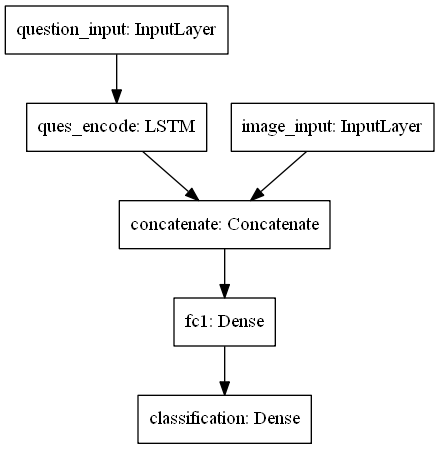

In [16]:
plot_model(model)

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

checkpoint_filepath = '../datasets/vqa-v1/weights.hdf5'

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(
    train_datagen, 
    epochs = 200,
    validation_data = val_datagen,
    callbacks = [model_checkpoint_callback]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 759 steps, validate for 365 steps
Epoch 1/200
759/759 [==============================] - 64s 85ms/step - loss: 3.1449 - accuracy: 0.2943 - val_loss: 2.5358 - val_accuracy: 0.3251
Epoch 2/200
759/759 [==============================] - 52s 68ms/step - loss: 2.3698 - accuracy: 0.3449 - val_loss: 2.2718 - val_accuracy: 0.3541
Epoch 3/200
759/759 [==============================] - 52s 68ms/step - loss: 2.0679 - accuracy: 0.3783 - val_loss: 2.0107 - val_accuracy: 0.3815
Epoch 4/200
759/759 [==============================] - 52s 68ms/step - loss: 1.8427 - accuracy: 0.4071 - val_loss: 1.8744 - val_accuracy: 0.4052
Epoch 5/200
759/759 [==============================] - 52s 68ms/step - loss: 1.7131 - accuracy: 0.4302 - val_loss: 1.8177 - val_accuracy: 0.4116
Epoch 6/200
759/759 [==============================] - 52s 68ms/step - loss: 1.6295 - accuracy: 0.4436 - val_loss: 1.7733 - val_accuracy: 0.4203
Epoch 7/200
759/759 [===============

Epoch 56/200
759/759 [==============================] - 52s 68ms/step - loss: 0.7875 - accuracy: 0.6727 - val_loss: 2.9780 - val_accuracy: 0.4371
Epoch 57/200
759/759 [==============================] - 52s 68ms/step - loss: 0.7805 - accuracy: 0.6760 - val_loss: 3.0071 - val_accuracy: 0.4357
Epoch 58/200
759/759 [==============================] - 52s 68ms/step - loss: 0.7687 - accuracy: 0.6805 - val_loss: 3.1026 - val_accuracy: 0.4320
Epoch 59/200
759/759 [==============================] - 52s 68ms/step - loss: 0.7680 - accuracy: 0.6806 - val_loss: 3.1363 - val_accuracy: 0.4356
Epoch 60/200
759/759 [==============================] - 52s 68ms/step - loss: 0.7558 - accuracy: 0.6856 - val_loss: 3.1538 - val_accuracy: 0.4350
Epoch 61/200
759/759 [==============================] - 52s 68ms/step - loss: 0.7516 - accuracy: 0.6869 - val_loss: 3.1609 - val_accuracy: 0.4366
Epoch 62/200
759/759 [==============================] - 52s 68ms/step - loss: 0.7440 - accuracy: 0.6905 - val_loss: 3.2832 -

759/759 [==============================] - 52s 68ms/step - loss: 0.5342 - accuracy: 0.7822 - val_loss: 5.2112 - val_accuracy: 0.4232
Epoch 113/200
759/759 [==============================] - 52s 68ms/step - loss: 0.5289 - accuracy: 0.7842 - val_loss: 5.0495 - val_accuracy: 0.4247
Epoch 114/200
759/759 [==============================] - 52s 68ms/step - loss: 0.5247 - accuracy: 0.7849 - val_loss: 5.2519 - val_accuracy: 0.4222
Epoch 115/200
759/759 [==============================] - 52s 68ms/step - loss: 0.5242 - accuracy: 0.7867 - val_loss: 5.2388 - val_accuracy: 0.4246
Epoch 116/200
759/759 [==============================] - 52s 68ms/step - loss: 0.5263 - accuracy: 0.7857 - val_loss: 5.2114 - val_accuracy: 0.4231
Epoch 117/200
759/759 [==============================] - 52s 68ms/step - loss: 0.5208 - accuracy: 0.7882 - val_loss: 5.2501 - val_accuracy: 0.4219
Epoch 118/200
759/759 [==============================] - 52s 68ms/step - loss: 0.5186 - accuracy: 0.7893 - val_loss: 5.3403 - val_ac

Epoch 168/200
759/759 [==============================] - 52s 68ms/step - loss: 0.4242 - accuracy: 0.8336 - val_loss: 7.0192 - val_accuracy: 0.4188
Epoch 169/200
759/759 [==============================] - 52s 68ms/step - loss: 0.4187 - accuracy: 0.8354 - val_loss: 7.1428 - val_accuracy: 0.4184
Epoch 170/200
759/759 [==============================] - 52s 68ms/step - loss: 0.4171 - accuracy: 0.8365 - val_loss: 6.9500 - val_accuracy: 0.4155
Epoch 171/200
759/759 [==============================] - 52s 68ms/step - loss: 0.4127 - accuracy: 0.8375 - val_loss: 7.1936 - val_accuracy: 0.4183
Epoch 172/200
759/759 [==============================] - 52s 68ms/step - loss: 0.4104 - accuracy: 0.8385 - val_loss: 7.0792 - val_accuracy: 0.4156
Epoch 173/200
759/759 [==============================] - 52s 68ms/step - loss: 0.4150 - accuracy: 0.8376 - val_loss: 6.9637 - val_accuracy: 0.4161
Epoch 174/200
759/759 [==============================] - 52s 68ms/step - loss: 0.4146 - accuracy: 0.8373 - val_loss: 7

In [18]:
'''
test_datagen = datagen(test_data_whatanimal, 'train2014', batch_size=32, predict_mode=True)
test_output = model.predict(test_datagen)
answers[np.argmax(test_output)]
'''

"\ntest_datagen = datagen(test_data_whatanimal, 'train2014', batch_size=32, predict_mode=True)\ntest_output = model.predict(test_datagen)\nanswers[np.argmax(test_output)]\n"

In [19]:
model.load_weights(checkpoint_filepath)